In [84]:
from data_processing import *
from model_training import *

import glob
import math
import pandas as pd
import numpy as np
import scipy
from scipy.signal import find_peaks, peak_prominences, peak_widths
import matplotlib.pyplot as plt
import warnings
from os import path
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'tensorflow'

In [79]:
columns = pd.read_csv('data/columns.txt', header=None)
columns_list = columns.transpose().values.tolist()[0]

sensors = ['leftJointPosition', 'rightJointPosition', 'leftJointVelocity',
           'rightJointVelocity', 'imuGyroX', 'imuGyroY', 'imuGyroZ', 'imuAccX',
           'imuAccY', 'imuAccZ']

mode_pool = ['L0R0']
# mode_pool = ['L0R0', 'L0R1', 'L1R0', 'L1R1', 'L1R2', 'L2R1', 'L2R2', 'L3R0', 'L3R1']
trial_pool = [1, 2]
data_all = []

data_dir = 'data/'
for mode in mode_pool:
    for trial in trial_pool:
        file_path = data_dir+'log_'+str(mode)+'_'+str(trial)+'.txt'
        if path.exists(file_path) == 1:
            for read_path in glob.glob(file_path):
                data = pd.read_csv(read_path, sep=" ", header=None)
                data = data.iloc[:,0:15]
                data.columns = columns_list
                data = data[sensors]
                data_all.append(data)

In [80]:
left_joint_positions, right_joint_positions = extract_joint_positions(data_all)

labels = []
for i in range(len(data_all)):
    left_x, left_y = label_vectors(left_joint_positions[i])
    right_x, right_y = label_vectors(right_joint_positions[i])
    label_df = pd.DataFrame({'leftGaitPhaseX': left_x, 'leftGaitPhaseY': left_y,
                             'rightGaitPhaseX': right_x, 'rightGaitPhaseY': right_y})
    labels.append(label_df)

# Combine the data and the labels
for d, l in zip(data_all, labels):
    d[l.columns] = l

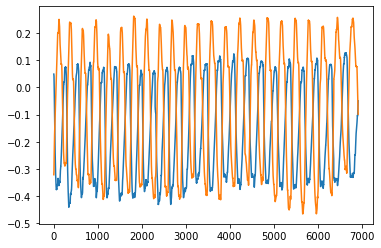

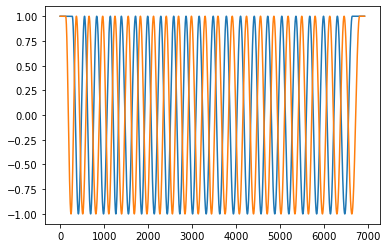

In [81]:
idx = 0
plt.plot(data_all[idx]['leftJointPosition'])
plt.plot(data_all[idx]['rightJointPosition'])
plt.show()

plt.plot(data_all[idx]['leftGaitPhaseX'])
plt.plot(data_all[idx]['rightGaitPhaseX'])
plt.show()

In [82]:
hyperparam_space = {
    'window_size': [20],
    'model': 'cnn',
    'cnn': {
      'kernel_size': [10],
      'activation': ['relu']
    },
    'dense': {
        'activation': ['tanh']
    },
    'optimizer': {
        'loss': ['mean_absolute_error'],
        'optimizer': ['adam']
    },
    'training': {
        'epochs': [10],
        'batch_size': [128]
    }
}

In [83]:
trial_results, average_results = train_models(hyperparam_space['model'], hyperparameter_configs, data_list)

NameError: name 'train_models' is not defined